### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, restoration, filters

# Modules
from RICM_VESICLE import RICM

# Functions
def avg_movie(movie, l=2, show_dim=True):
    
    # Average each l frames
    movie_consecutive = []
    for i in range(int(movie.shape[0])):
        if movie.shape[0] - i >= l:
            movie_consecutive.append(np.mean(movie[i:i+l], axis=0))

    # Transform the movie into numpy array
    movie_consecutive = np.array(movie_consecutive)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_consecutive.shape))
    
    return movie_consecutive

### Determine the Movie

In [2]:
# Determine the Experiment, Shot and the GUV number
EXPERIMENT = '20210112_Ecad_dynamics'
DATA = 'movie-200-550ms-1200-1sec_240_1200-1sec'
SHOT, GUV = "", 2

### Read the first part of the RICM image to determine the base line

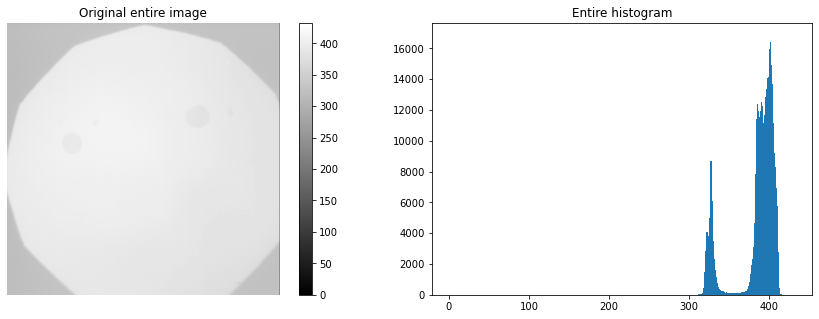

In [3]:
# Read the RICM image
RICM_img = io.imread("{}/data/{}.tif".format(EXPERIMENT, DATA))[:200].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(RICM_img.ravel(), bins = 1000);
#plt.xlim(300,450);

### Read the first part of the RICM image for one GUV

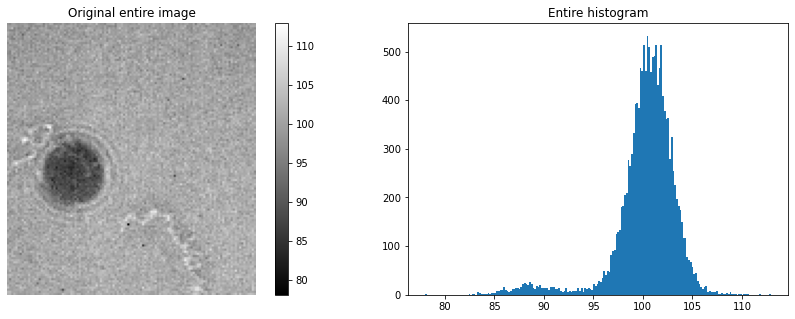

In [4]:
# Read the image
guv = io.imread("{}/data/{}{}-{}.tif".format(EXPERIMENT,DATA, SHOT, GUV))[60:200]

# Subtract the base line
guv = guv - 310

# Take the average
guv_avg = guv[-50:].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

### Define the RICM model to get the bacground corrected image

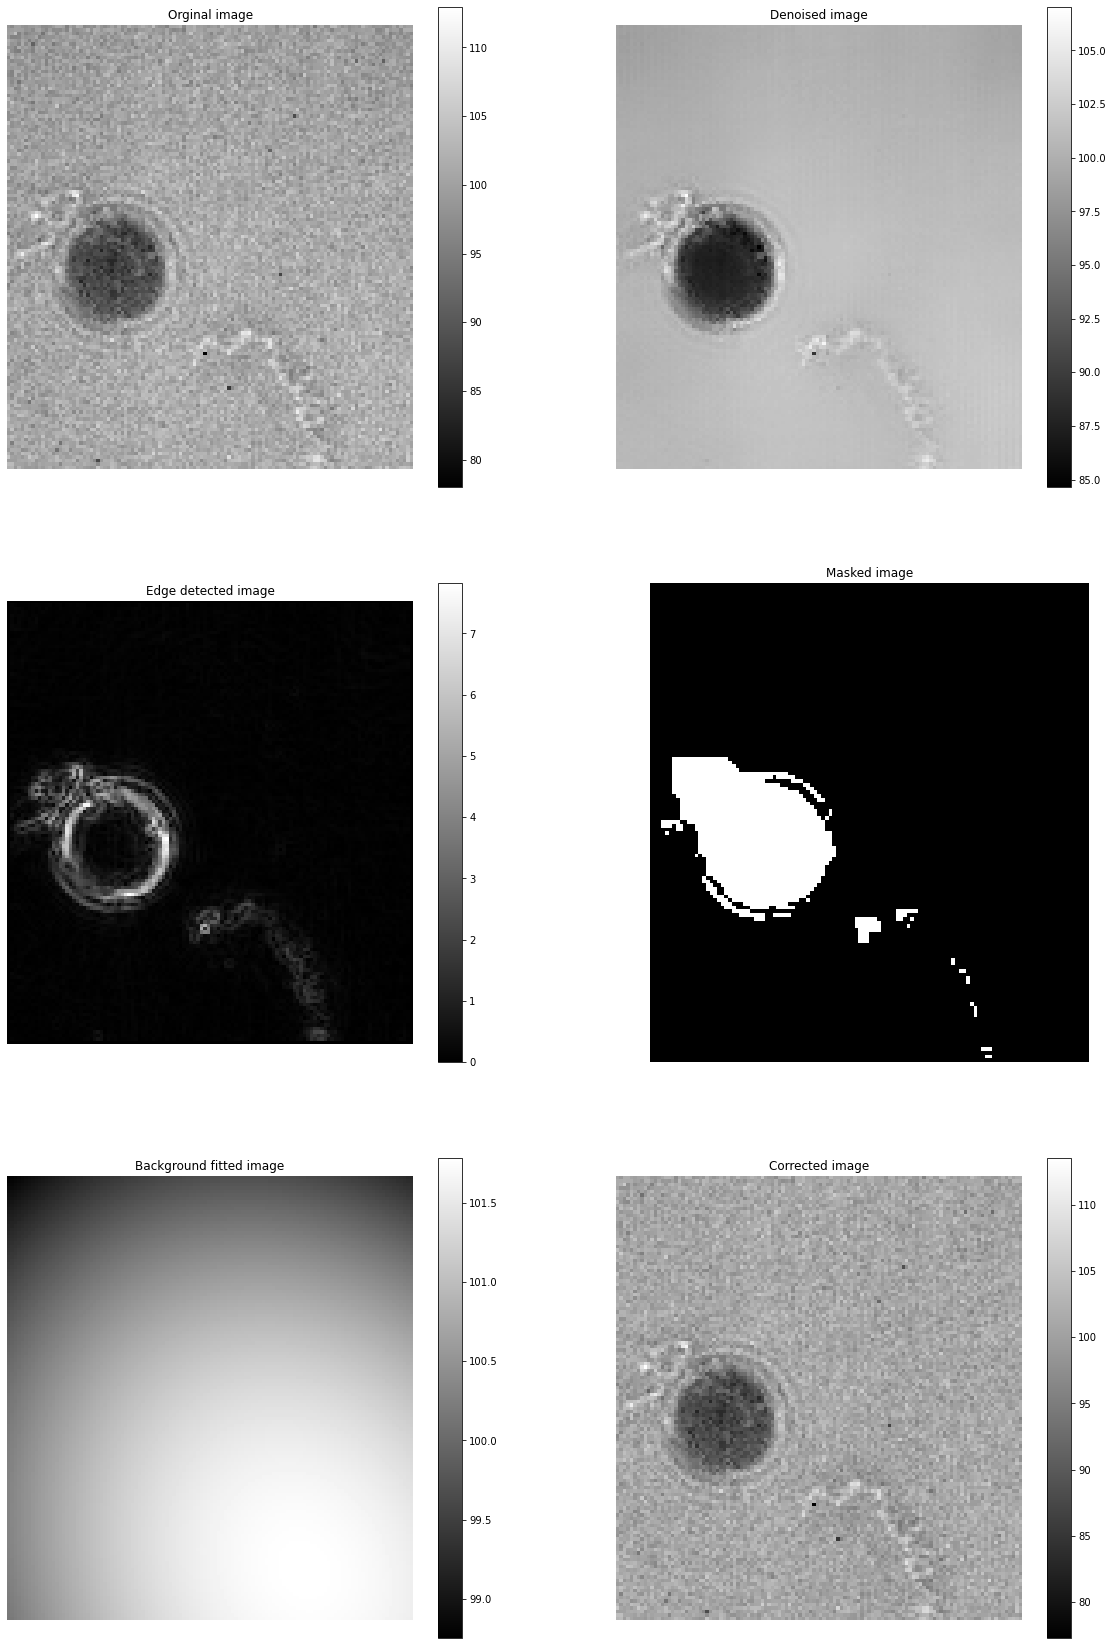

In [5]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

### The histogram of the corrected GUV

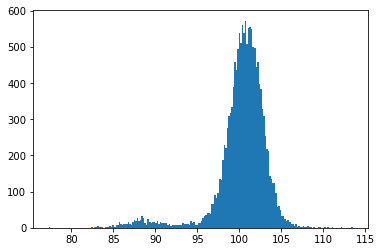

In [6]:
plt.hist(ricm.correct().ravel(), bins = 200);

### Take a cosecutive average of the GUV movie

In [7]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(140, 129, 118) --> (135, 129, 118)


### Measure the area of each frame
#### With background correction

In [8]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm on the background corrected image
    img_corrected = restoration.denoise_nl_means(guv_consecutive[i] + background_correction,
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)

    # Compute the area
    area.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)

CPU times: user 35.9 s, sys: 20.4 ms, total: 35.9 s
Wall time: 34.6 s


### Plote and save the area curves

(135,) (135,)


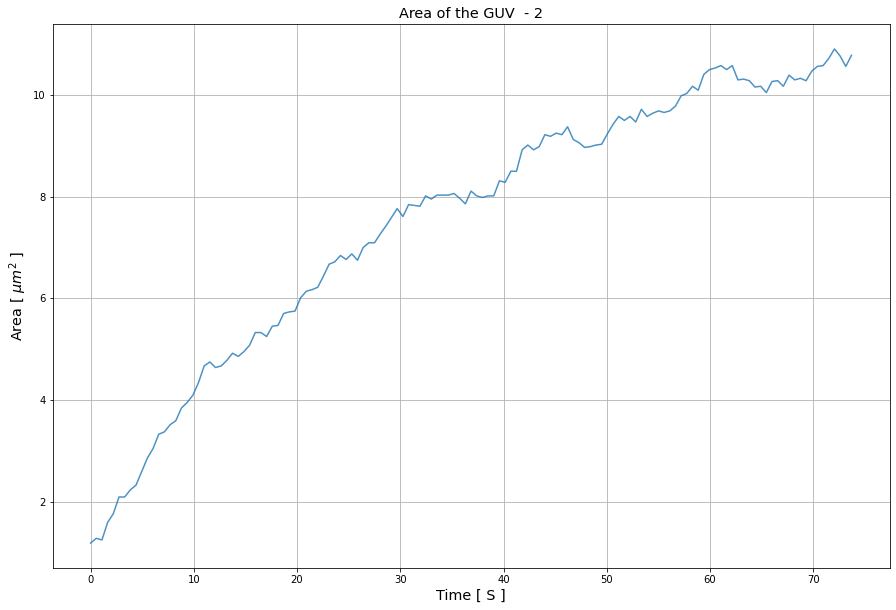

In [9]:
# Define the curve and the time interval
area_curve = area[:] * 0.125**2
time = np.arange(0, int(area_curve.shape[0]*0.550), 0.550)

print(time.shape, area_curve[:].shape)

# Define data frame for the scaled time and area
df1 = pd.DataFrame(data={'Time':time, 'Area':area_curve})

# Plot the curve
plt.figure(figsize=(15, 10))
plt.plot(df1['Time'], df1['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.grid()

# the second part

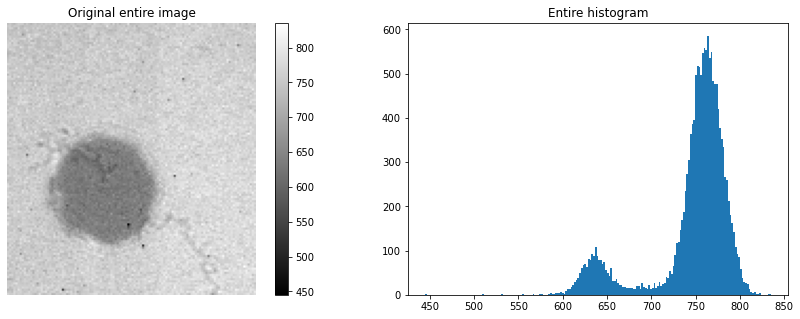

In [10]:
# Read the image
guv = io.imread("{}/data/{}{}-{}.tif".format(EXPERIMENT,DATA, SHOT, GUV))[200:]

# Subtract the base line
guv = guv - 310

# Take the average
guv_avg = guv[-100:].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

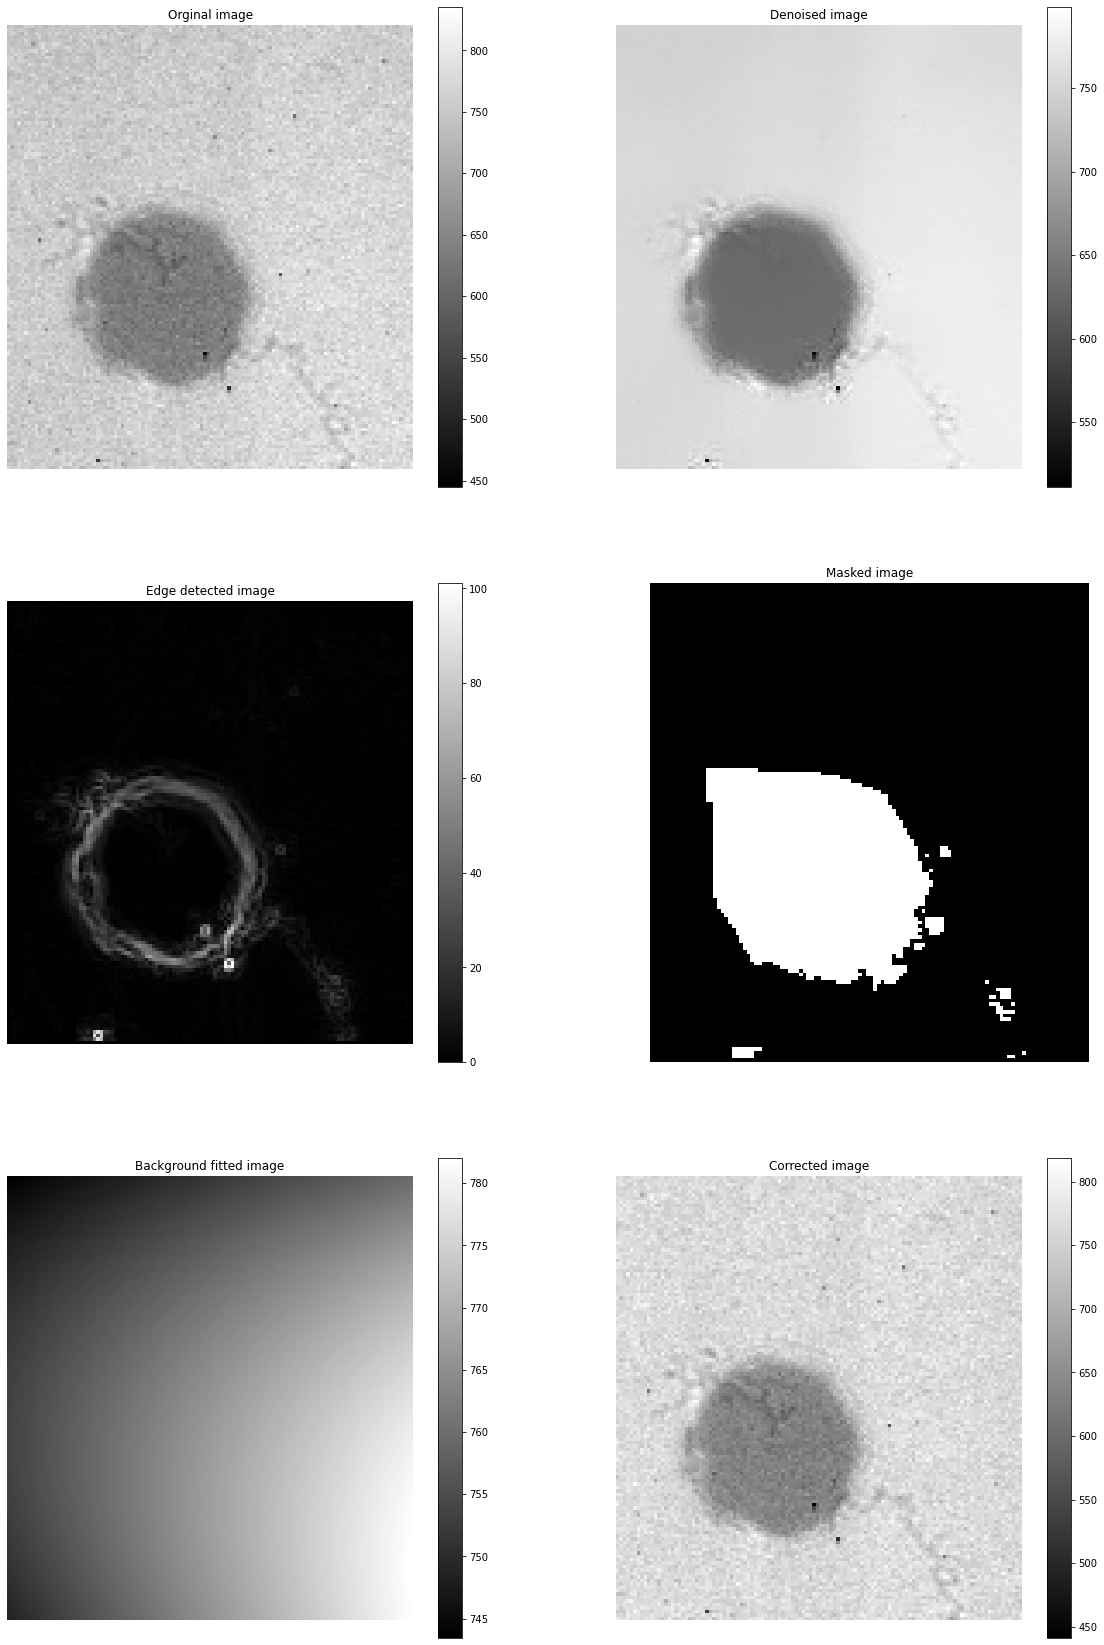

In [11]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

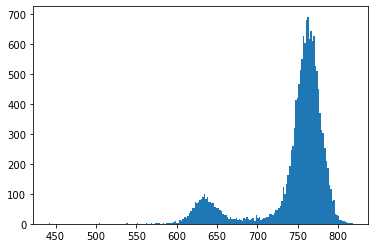

In [12]:
plt.hist(ricm.correct().ravel(), bins = 200);

### Take a cosecutive average of the GUV movie

In [13]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(2400, 129, 118) --> (2395, 129, 118)


In [14]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area_big = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm
    img_corrected = restoration.denoise_nl_means(guv_consecutive[i] + background_correction,
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)

    # Compute the area
    area_big.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area_big = np.array(area_big)

CPU times: user 9min 57s, sys: 842 ms, total: 9min 58s
Wall time: 9min 57s


(2395,) (2395,)


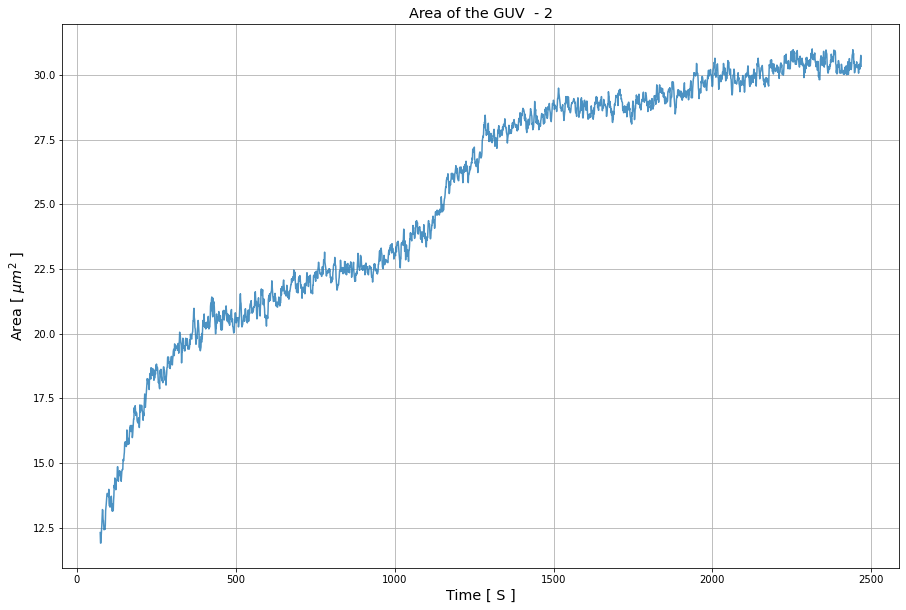

In [15]:
# Define the curve and the time interval
area_curve = area_big[:] * 0.125**2
time = np.arange(time[-1], time[-1] + int(area_curve.shape[0]*1), 1)

print(time.shape, area_curve[:].shape)

# Define data frame for the scaled time and area
df2 = pd.DataFrame(data={'Time':time, 'Area':area_curve})

# Plot the curve
plt.figure(figsize=(15, 10))
plt.plot(df2['Time'], df2['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.grid()

### The whole curve

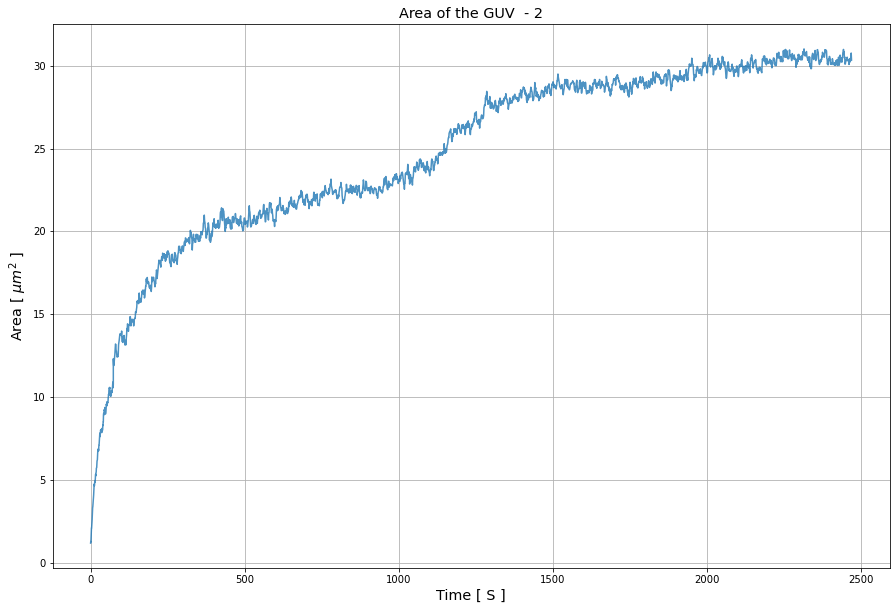

In [16]:
# Concatenating the two data frames
df = pd.concat([df1, df2])

# Plot the curve
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.grid()
plt.savefig("{}/results/{}{}-{}".format(EXPERIMENT, DATA, SHOT, GUV))

# Save the data
df.to_csv("{}/results/{}{}-{}.csv".format(EXPERIMENT, DATA, SHOT, GUV), index=False)

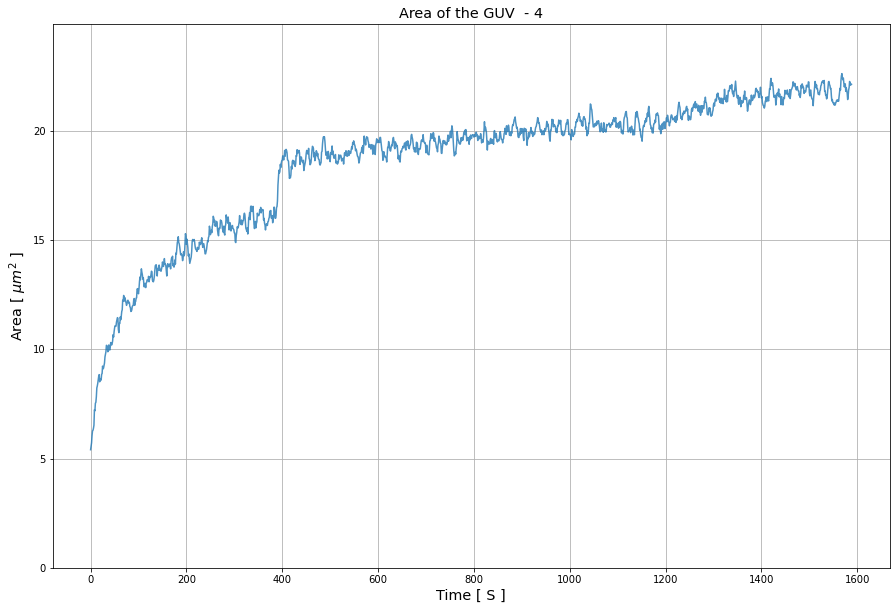

In [10]:
# Determine the Experiment, Shot and the GUV number
EXPERIMENT = '20210112_Ecad_dynamics'
DATA = 'movie-200-550ms-1200-1sec_240_1200-1sec'
SHOT, GUV = "", 4

# Read the data frame of the scaled time and area
df = pd.read_csv('{}/results/{}{}-{}.csv'.format(EXPERIMENT, DATA, SHOT, GUV))

# Plot the curve
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.ylim(0,df['Area'].max() + df['Area'].max()/10)
plt.grid()
plt.savefig("{}/results/{}{}-{}_FromZero".format(EXPERIMENT, DATA, SHOT, GUV))